## Metacritic Data Analysis

In [1]:
%matplotlib inline

In [2]:
# Import necessary packages
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

# Set format and style for plots
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 
plt.rcParams["figure.figsize"] = [10.0,5.0]

### Load and Clean Data

In [3]:
# Read in metacritic data
metacritic = pd.read_csv('metacritic.csv')
metacritic.head(5)

Length      Seasons                  Name  Rank  CriticNum  CriticR  \
0      90      1,2,3,4    Sherlock: Season 3   100         23       88   
1      60  1,2,3,4,5,6   Justified: Season 5   200         14       84   
2      60  1,2,3,4,5,6        Lost: Season 5   400         17       78   
3      60          1,2        Boss: Season 2   500         18       75   
4      60          1,2  Murder One: Season 2   600         16       73   

     SeasonDate                                              Genre Network  \
0  Jul 25, 2010                                     Drama,Suspense   BBC-1   
1  Mar 16, 2010                           Drama,Action & Adventure      FX   
2  Sep 22, 2004  Drama,Action & Adventure,Fantasy,Suspense,Scie...     ABC   
3  Oct 21, 2011                                              Drama   Starz   
4  Sep 19, 1995                                              Drama     ABC   

   UserNum UserR    SeriesDate  
0    700.0   8.5  Jan  1, 2014  
1    180.0   8.4  Jan  7, 2014  
2    383.0   8.6  Jan 21, 2009  
3     39.0   8.5  Aug 17, 2012  
4      NaN   tbd  Oct 10, 1996

In [4]:
# Make a copy of dataframe to maintain original
metacritic_ = metacritic.copy()

# Rename columns in dataframe
metacritic_.columns = metacritic_.columns.str.replace("Name", "SeasonName") 
metacritic_.columns = metacritic_.columns.str.replace("SeasonDate", "SrsDate")
metacritic_.columns = metacritic_.columns.str.replace("SeriesDate", "SeasonDate")

#Format dates as date objects
metacritic_["SeasonDate"] = metacritic_.SeasonDate.apply(lambda x: datetime.strptime(x, '%b %d, %Y')) 
metacritic_["SrsDate"] = metacritic_.SrsDate.apply(lambda x: datetime.strptime(x, '%b %d, %Y'))

In [5]:
# Create new columns with total # of seasons and series name
metacritic_["TotalSeasons"] = metacritic_.Seasons.apply(lambda x: x.split(',')[-1])
metacritic_["SeriesName"] = metacritic_.SeasonName.apply(lambda x: x.split(':')[0])

# Create new columns with season and series years
metacritic_["SeasonYr"] = metacritic_.SeasonDate.apply(lambda x: x.year)
metacritic_["SeriesYr"] = metacritic_.SrsDate.apply(lambda x: x.year)

In [6]:
# View numeric columns
metacritic_.describe()

Length         Rank    CriticNum      CriticR      UserNum  \
count  1928.000000  1928.000000  1928.000000  1928.000000  1792.000000   
mean     54.983921  1028.596473    18.014004    63.479772   131.537388   
std      27.353331   595.881626     7.926643    15.971550   271.379874   
min       2.000000     1.000000     7.000000    13.000000     4.000000   
25%      30.000000   514.750000    11.000000    53.000000    22.750000   
50%      60.000000  1028.500000    18.000000    65.000000    52.000000   
75%      60.000000  1545.250000    24.000000    75.000000   128.000000   
max     464.000000  2056.000000    45.000000    99.000000  4016.000000   

          SeasonYr     SeriesYr  
count  1928.000000  1928.000000  
mean   2009.946577  2009.411307  
std       5.956402     6.017395  
min    1981.000000  1985.000000  
25%    2007.000000  2006.000000  
50%    2011.000000  2011.000000  
75%    2014.000000  2014.000000  
max    2017.000000  2017.000000

In [7]:
# View columns with null values
np.sum(metacritic_.isnull())# UserNum is the only column with null values; some shows don't have user reviews

Length            0
Seasons           0
SeasonName        0
Rank              0
CriticNum         0
CriticR           0
SrsDate           0
Genre             0
Network           0
UserNum         136
UserR             0
SeasonDate        0
TotalSeasons      0
SeriesName        0
SeasonYr          0
SeriesYr          0
dtype: int64

In [8]:
#Replace "tbd" User Rating values with NaN
metacritic_["UserR"] = metacritic_["UserR"].replace(to_replace="tbd", value=np.nan)

In [9]:
# Convert User Rating and Total Season values to numeric
metacritic_["UserR"] = pd.to_numeric(metacritic_["UserR"])
metacritic_["TotalSeasons"] = pd.to_numeric(metacritic_["TotalSeasons"])

# Multiply User Rating by 10 so scale is equivalent to Critic Rating
metacritic_["UserR"] = metacritic_.UserR.apply(lambda x: x * 10)

In [10]:
# Write function to descibe critic rating based on score
def R_descrip(df):
    if df['CriticR'] > 80:
        val = "Universal Acclaim"
    elif df['CriticR'] <= 80 and df['CriticR'] > 60:
        val = "Favorable"
    elif df['CriticR'] <= 60 and df['CriticR'] > 39:
        val = "Average"
    else:
        val = "Unfavorable"
    return val

In [11]:
# Apply R_descrip function to dataframe
metacritic_['RDescrip'] = metacritic_.apply(R_descrip, axis=1)
metacritic_.head(2)

Length      Seasons           SeasonName  Rank  CriticNum  CriticR  \
0      90      1,2,3,4   Sherlock: Season 3   100         23       88   
1      60  1,2,3,4,5,6  Justified: Season 5   200         14       84   

     SrsDate                     Genre Network  UserNum  UserR SeasonDate  \
0 2010-07-25            Drama,Suspense   BBC-1    700.0   85.0 2014-01-01   
1 2010-03-16  Drama,Action & Adventure      FX    180.0   84.0 2014-01-07   

   TotalSeasons SeriesName  SeasonYr  SeriesYr           RDescrip  
0           4.0   Sherlock      2014      2010  Universal Acclaim  
1           6.0  Justified      2014      2010  Universal Acclaim

### Data Analysis and Visualization

#### Analysis of Critic v. User Ratings

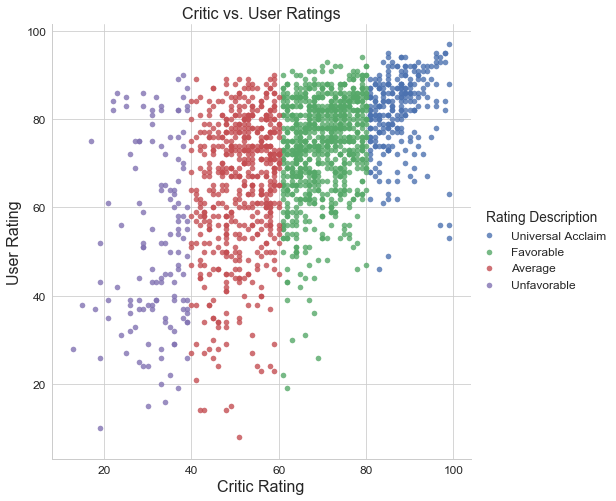

In [70]:
# Create scatterplot of critic vs. user rating
sns.lmplot(x="CriticR", y="UserR", hue="RDescrip", data=metacritic_, fit_reg=False, size=7)\
.set_axis_labels("Critic Rating", "User Rating")._legend.set_title("Rating Description")  

# Add plot title
plt.title("Critic vs. User Ratings")

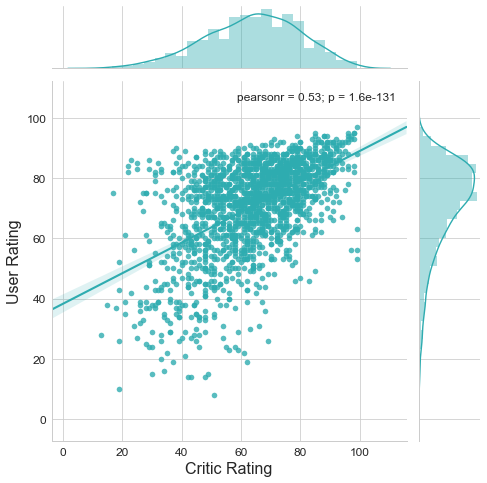

In [13]:
# Create joint plot of critic vs. user rating and density curves
sns.jointplot(metacritic_['CriticR'], metacritic_['UserR'], size=7, color="#2eacb0", kind="reg")\
.set_axis_labels("Critic Rating", "User Rating")

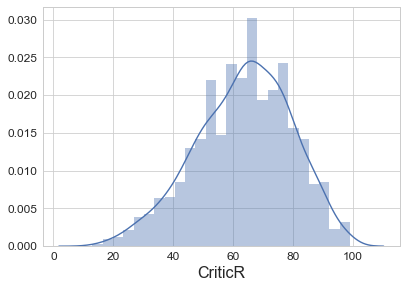

In [16]:
# Plot distribution of critic ratings
sns.distplot(metacritic_['CriticR'])

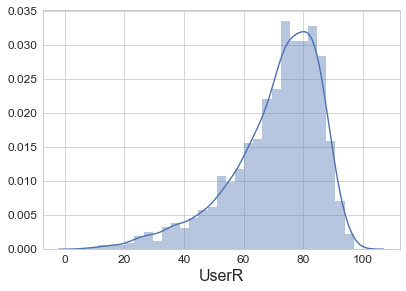

In [17]:
# Plot distribution of user ratings
userR = metacritic_["UserR"].dropna() #Drop missing values
sns.distplot(userR)

In [74]:
# Create boxplot of critic vs. user rating distribution
sns.boxplot(data=metacritic_.loc[:,["CriticR", "UserR"]], orient = "h", palette="Set1")

# Add plot title
plt.title("Critic vs. User Rating Distribution")

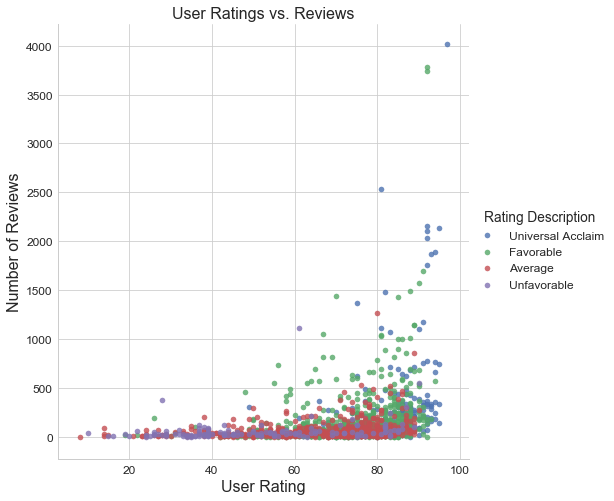

In [19]:
# Create scatterplot of user count vs. user review - are people more likely to review a good show?
sns.lmplot("UserR", "UserNum", metacritic_, hue= "RDescrip", size=7, fit_reg=False)\
.set_axis_labels("User Rating", "Number of Reviews")._legend.set_title("Rating Description")

# Add plot title
plt.title("User Ratings vs. Reviews")

In [20]:
# Create joint plot of user count vs. user review - are people more likely to review a good show?
sns.jointplot(metacritic_['UserR'], metacritic_['UserNum'], size=7, color="#2eacb0", kind="reg")\
.set_axis_labels("User Rating", "Number of Reviews")

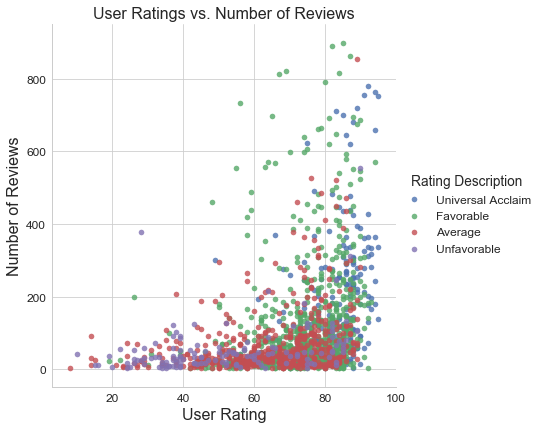

In [21]:
# Remove outliers from previous graph to improve visual - slightly stronger correlation
reviews = metacritic_.loc[metacritic_[['UserNum']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

sns.lmplot("UserR", "UserNum", reviews, hue= "RDescrip", size = 6, fit_reg=False)\
.set_axis_labels("User Rating", "Number of Reviews")._legend.set_title("Rating Description")

# Add plot title
plt.title("User Ratings vs. Number of Reviews")

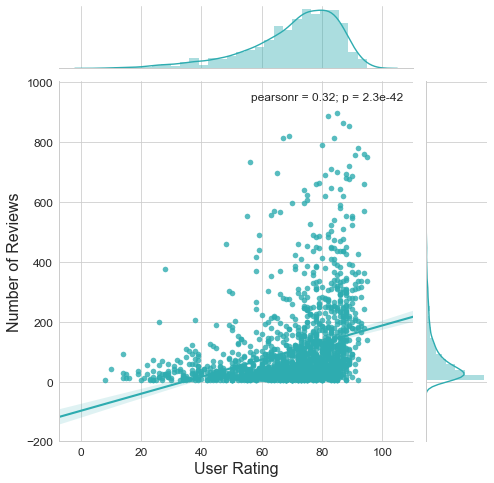

In [22]:
# Create joint plot of user rating vs. number of reviews with outliers removed
sns.jointplot(reviews['UserR'], reviews['UserNum'], size=7, color="#2eacb0", kind="reg")\
.set_axis_labels("User Rating", "Number of Reviews")

#### Analysis of Shows by Year

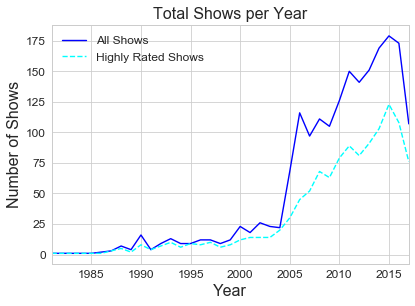

In [28]:
# Plot number of shows by year and # of shows with ratings over 60 by year
top_shows = metacritic_.loc[metacritic_['CriticR'] > 60]
metacritic_.groupby("SeasonYr").size().plot.line(color="blue", label = "All Shows")
top_shows.groupby("SeasonYr").size().plot.line(color="cyan", linestyle='--', label = "Highly Rated Shows")

# Format plot
plt.legend()
plt.xlabel("Year")
plt.ylabel("Number of Shows")
plt.title("Total Shows per Year")

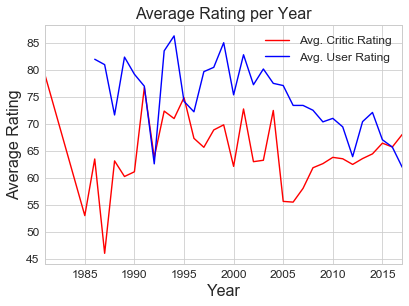

In [29]:
# Plot average critic and user rating by year 
metacritic_.groupby("SeasonYr")['CriticR'].mean().plot.line(color="red", label = "Avg. Critic Rating")
metacritic_.groupby("SeriesYr")['UserR'].mean().plot.line(color="blue", label = "Avg. User Rating")

# Format plot
plt.legend()
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.title("Average Rating per Year")

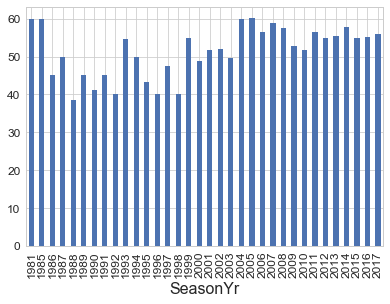

In [30]:
# Plot average show length by year - no interesting pattern
metacritic_.groupby("SeasonYr")["Length"].mean().plot.bar()

In [31]:
# Prepare data to be grouped by overall Series name 
# Get high-level Series information and drop duplicates
series = metacritic_[["SeriesName", "SeriesYr", "TotalSeasons", "Network", "Length"]].sort_values(by='SeriesName')
series = series.drop_duplicates()
series.head()

SeriesName  SeriesYr  TotalSeasons     Network  Length
1807       'Til Death Do Us Part      2007           1.0    Court TV      30
191                     1 vs 100      2006           3.0         NBC      60
1788            10 Items Or Less      2006           3.0       Other      30
684   10 Things I Hate About You      2009           2.0  ABC Family      30
1616                        10.5      2006           1.0         NBC     240

In [32]:
# Prepare data to be grouped by overall Series name 
# Get average Critic and User ratings for each series
series_ = metacritic_.groupby("SeriesName")[['CriticR','UserR']].mean()
series_.head()

CriticR  UserR
SeriesName                                
'Til Death Do Us Part          43.0   77.0
1 vs 100                       54.0   74.0
10 Items Or Less               42.0   58.0
10 Things I Hate About You     66.0   66.0
10.5                           23.0   42.0

In [33]:
# Merge overall Series information and average reviews together
series2 = pd.merge(series, series_, how="left", left_on = "SeriesName", right_index = True)
series2.head()

SeriesName  SeriesYr  TotalSeasons     Network  Length  \
1807       'Til Death Do Us Part      2007           1.0    Court TV      30   
191                     1 vs 100      2006           3.0         NBC      60   
1788            10 Items Or Less      2006           3.0       Other      30   
684   10 Things I Hate About You      2009           2.0  ABC Family      30   
1616                        10.5      2006           1.0         NBC     240   

      CriticR  UserR  
1807     43.0   77.0  
191      54.0   74.0  
1788     42.0   58.0  
684      66.0   66.0  
1616     23.0   42.0

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 <a list of 34 Text xticklabel objects>)

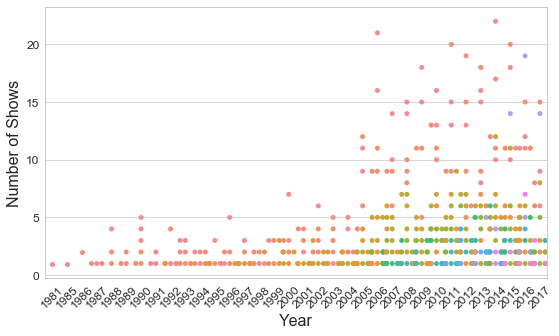

In [38]:
# Plot all networks with at least one show by year - hard to read this graph
swarm_data = metacritic_.groupby(["SeasonYr", "Network"]).size().reset_index()
sns.swarmplot(x="SeasonYr", y=0, hue="Network", data=swarm_data).legend_.remove()

# Format plot
plt.xlabel("Year")
plt.ylabel("Number of Shows")
plt.xticks(rotation=45)

In [40]:
# Second attempt to graph number of networks by year
swarm_data.groupby("SeasonYr").size().plot.line(color="magenta", label = "Number of Networks")

# Format plot
plt.xlabel("Year")
plt.ylabel("Number of Networks")
plt.title("Number of Networks per Year")

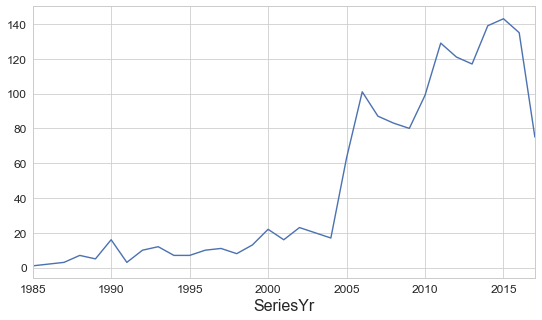

In [44]:
# Plot number of series by year - similar trend to number of seasons by year
series2.groupby("SeriesYr").size().plot.line()

#### Analysis of # Seasons vs. Reviews

In [45]:
# Create bar chart of total number of seasons 
totalseasons = series2.loc[series2["TotalSeasons"] < 35]
totalseasons.TotalSeasons = totalseasons.TotalSeasons.astype(int)
sns.countplot(x="TotalSeasons", data=totalseasons, palette="GnBu_d")\
.set(xlabel="Number of Seasons", ylabel= "Count")

# Format plot
plt.title("Total Number of Seasons")

C:\Users\jgoldste\Anaconda2\envs\py35\lib\site-packages\pandas\core\generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


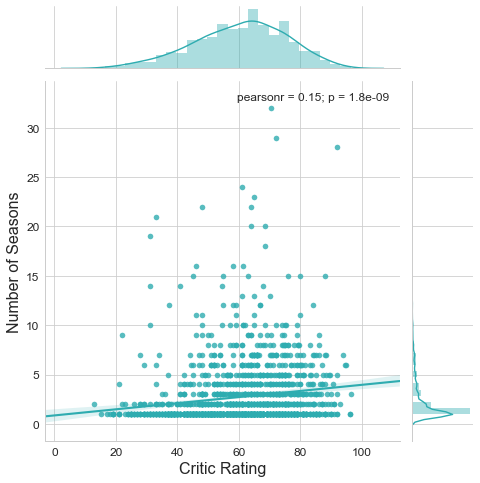

In [46]:
# Plot correlation between critic review and number of seasons 
sns.jointplot(totalseasons["CriticR"], totalseasons["TotalSeasons"], size=7, color="#2eacb0", kind="reg")\
.set_axis_labels("Critic Rating", "Number of Seasons")

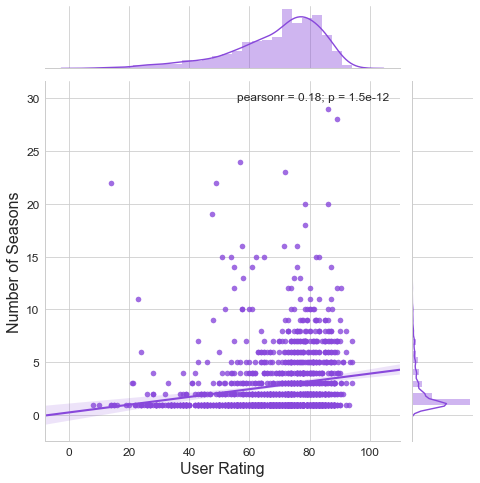

In [48]:
# Plot correlation between user review and number of seasons 
sns.jointplot(totalseasons["UserR"], totalseasons["TotalSeasons"], size=7, color="#8848db", kind="reg")\
.set_axis_labels("User Rating", "Number of Seasons")

#### Analysis of Networks

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

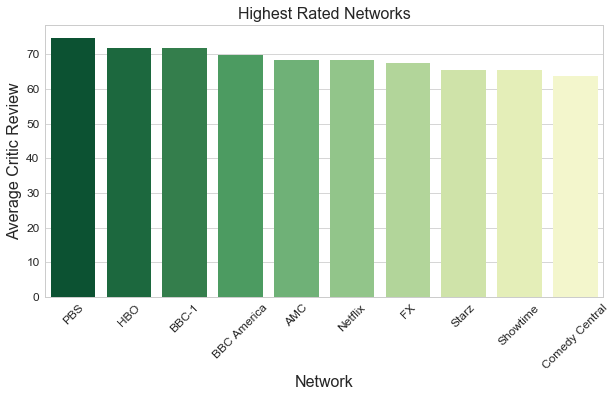

In [77]:
# Group high-level series data by Network 
networks = series2.groupby('Network')
networks = networks.filter(lambda x: x["Network"].count() > 15)

# Show top 10 networks with more than 15 shows
networkbar2 = networks.groupby('Network').mean()[['CriticR']].reset_index().sort_values(by="CriticR", ascending=False).head(10)
sns.barplot(x="Network", y="CriticR", palette = "YlGn_r", data=networkbar2)\
.set(xlabel="Network", ylabel= "Average Critic Review")

# Format plot
plt.title("Highest Rated Networks")
plt.xticks(rotation=45)

In [78]:
# Plot bottom 10 networks with more than 15 shows
networkbar3 = networks.groupby('Network').mean()[['CriticR']].reset_index().sort_values(by="CriticR").head(10)
sns.barplot(x="Network", y="CriticR", palette = "OrRd_r", data=networkbar3)\
.set(xlabel="Network", ylabel= "Average Critic Review")

# Format plot
plt.title("Lowest Rated Networks")
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

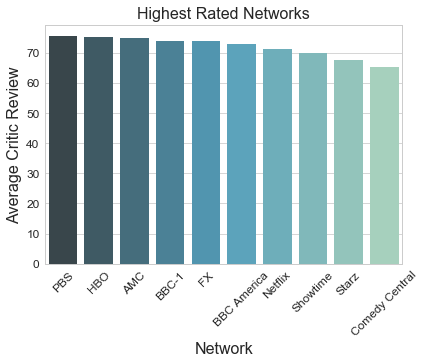

In [26]:
# Create dataframe grouped by Network, filtered by Networks with more than 20 seaons
network_group = metacritic_.groupby('Network')
network_group = network_group.filter(lambda x: x["Network"].count() > 20)

# Create bar chart with top 10 Networks by average critic rating
networkbar = network_group.groupby('Network').mean()[['CriticR']].reset_index().sort_values(by="CriticR", ascending=False).head(10)
sns.barplot(x="Network", y="CriticR", palette = "GnBu_d", data=networkbar)\
.set(xlabel="Network", ylabel= "Average Critic Review")

# Format bar chart
plt.xticks(rotation=45)
plt.title("Highest Rated Networks")

#### Genre Analysis

In [53]:
# Split dataset by genre to account for shows with more than one genre
meta_genre = metacritic_.copy()
meta_genre.Genre = meta_genre.Genre.apply(lambda x: x.split(','))
meta_genre = pd.concat([pd.DataFrame(meta_genre.iloc[i].to_dict()) for i in range(len(meta_genre))])

meta_genre.head()

CriticNum  CriticR               Genre  Length Network           RDescrip  \
0         23       88               Drama      90   BBC-1  Universal Acclaim   
1         23       88            Suspense      90   BBC-1  Universal Acclaim   
0         14       84               Drama      60      FX  Universal Acclaim   
1         14       84  Action & Adventure      60      FX  Universal Acclaim   
0         17       78               Drama      60     ABC          Favorable   

   Rank SeasonDate           SeasonName  SeasonYr      Seasons SeriesName  \
0   100 2014-01-01   Sherlock: Season 3      2014      1,2,3,4   Sherlock   
1   100 2014-01-01   Sherlock: Season 3      2014      1,2,3,4   Sherlock   
0   200 2014-01-07  Justified: Season 5      2014  1,2,3,4,5,6  Justified   
1   200 2014-01-07  Justified: Season 5      2014  1,2,3,4,5,6  Justified   
0   400 2009-01-21       Lost: Season 5      2009  1,2,3,4,5,6       Lost   

   SeriesYr    SrsDate  TotalSeasons  UserNum  UserR  
0      2010 2010-07-25           4.0    700.0   85.0  
1      2010 2010-07-25           4.0    700.0   85.0  
0      2010 2010-03-16           6.0    180.0   84.0  
1      2010 2010-03-16           6.0    180.0   84.0  
0      2004 2004-09-22           6.0    383.0   86.0

In [57]:
# Plot ten most popular genres
popgenres = meta_genre.groupby("Genre").size().reset_index().sort_values(by = 0, ascending=False).head(10)

sns.barplot(x="Genre", y=0, palette = "RdPu_r", data=popgenres)\
.set(xlabel="Genre", ylabel= "Number of Shows")

# Format plot
plt.xticks(rotation=45)
plt.title("Most Popular Genres")

In [58]:
# Split data frame into top 100 shows and bottom 100 shows
bestshows = meta_genre.loc[(meta_genre["Rank"] >=1) & (meta_genre["Rank"] <=100)]
worstshows = meta_genre.loc[meta_genre["Rank"] >=1954]

In [61]:
# Plot top 100 shows by genre
bestbar = bestshows.groupby("Genre").size().reset_index().sort_values(by = 0, ascending=False).head(10)
sns.barplot(x="Genre", y=0, palette = "YlGn_r", data=bestbar)\
.set(xlabel="Genre", ylabel= "Number of Shows")

# Format plot
plt.xticks(rotation=45)
plt.title("Most Popular Genres Among Top Shows")

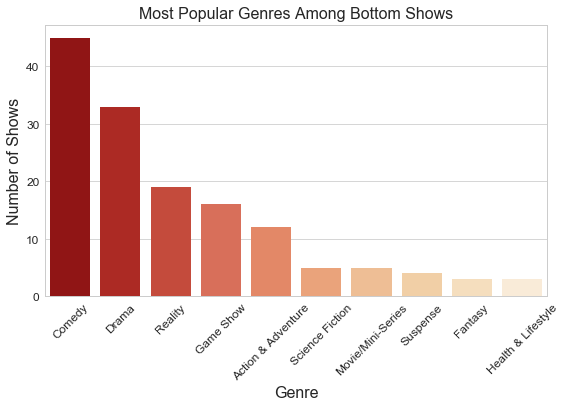

In [62]:
# Plot bottom 100 shows by genre
worstbar = worstshows.groupby("Genre").size().reset_index().sort_values(by = 0, ascending=False).head(10)
sns.barplot(x="Genre", y=0, palette = "OrRd_r", data=worstbar)\
.set(xlabel="Genre", ylabel= "Number of Shows")

# Format plot
plt.xticks(rotation=45)
plt.title("Most Popular Genres Among Bottom Shows")

In [63]:
# Plot genres based on average rating
genre_rating = meta_genre.groupby("Genre").mean()[["CriticR"]].reset_index().sort_values(by="CriticR", ascending=False)
sns.barplot(x="Genre", y="CriticR", palette = "GnBu_d", data=genre_rating)\
.set(xlabel="Genre", ylabel= "Average Critic Review")

# Format plot
plt.xticks(rotation=90)
plt.title("Genres by Overall Rating")

In [111]:
# Plot genres based on average rating
genre_rating2 = meta_genre.groupby("Genre").mean()[["UserR"]].reset_index().sort_values(by="UserR", ascending=False)
genre_rating2 = genre_rating2.dropna()
sns.barplot(x="Genre", y="UserR", palette = "RdPu_r", data=genre_rating2)\
.set(xlabel="Genre", ylabel= "Average User Review")

# Format plot
plt.xticks(rotation=90)
plt.title("Genres by Overall Rating")

#### Specific Show Analysis

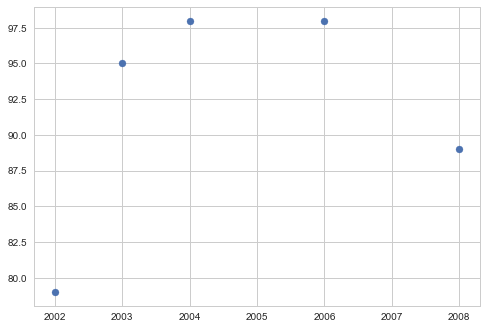

In [101]:
# Look at critic ratings for selected shows over time
wire = metacritic_.loc[metacritic_["SeriesName"] == "The Wire"]
plt.scatter(wire["SeasonYr"], wire["CriticR"]) 

In [94]:
breaking = metacritic_.loc[metacritic_["SeriesName"] == "Breaking Bad"]
plt.scatter(breaking["SeasonYr"], breaking["CriticR"])

In [95]:
madmen = metacritic_.loc[metacritic_["SeriesName"] == "Mad Men"]
plt.scatter(madmen["SeasonYr"], madmen["CriticR"]) # Can I plot user rating and critic rating on the same graph?

In [96]:
thrones = metacritic_.loc[metacritic_["SeriesName"] == "Game of Thrones"]
plt.scatter(thrones["SeasonYr"], thrones["CriticR"]) # Can I color these based on description, and add user scores?

#### Plotly Bubble Chart

In [17]:
# Create data frame for Network ratings bubble chart
network_bubble = series2.groupby("Network")

# Filter by Networks with over 15 shows
network_bubble = network_bubble.filter(lambda x: x["Network"].count() > 15)
network_bubble = network_bubble.groupby("Network").agg(["count", "mean"])[["CriticR", "UserR"]].iloc[:,[0,1,3]].reset_index()

In [13]:
#Import plotly for bubble chart graphic - cannot run simultaneously with seaborn
import plotly     
plotly.offline.init_notebook_mode()
from plotly.graph_objs import Scatter, Figure, Layout

2.0.12


In [24]:
# Create Network ratings bubble chart
trace0 = Scatter(
    x=network_bubble.iloc[:,2],
    y=network_bubble.iloc[:,3],
    text= network_bubble.iloc[:,0],
    mode='markers',
    marker=dict(
        color=['rgb(93, 164, 214)', 'rgb(255, 144, 14)',
               'rgb(44, 160, 101)', 'rgb(255, 65, 54)',
              'rgb(238, 22 22)', 'rgb(178, 24, 178)',
               'rgb(58, 52, 232)', 'rgb(109, 197, 242)',
              'rgb(109, 242, 180)', 'rgb(27, 155, 95)',
               'rgb(255, 250, 64)', 'rgb(255, 147, 23)',
              'rgb(170, 255, 23)', 'rgb(255, 151, 23)',
               'rgb(102, 178, 255)', 'rgb(153, 0, 0)',
              'rgb(0, 0, 102)', 'rgb(153, 0, 76)',
               'rgb(178, 102, 255)', 'rgb(51, 255, 255)',
                'rgb(102, 0, 102)', 'rgb(255, 0, 255)',
               'rgb(0, 76, 153)', 'rgb(255, 0, 127)',
              'rgb(102, 0, 102)', 'rgb(255, 0, 255)',],
        size=network_bubble.iloc[:,1],
    )
)

layout = Layout(
    title='Ratings and Number of Shows by Network',
    xaxis=dict(
        title='Critic Rating'
        ),
    yaxis=dict(
        title='User Rating'
        )
    )

data = [trace0]
fig = Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

#### Statistical Analysis

In [114]:
# Perform T-Tests comparing means of critic and user ratings for each ratings group
from scipy import stats
unfavorable = metacritic_.loc[metacritic_['RDescrip'] == "Unfavorable"]
stats.ttest_ind(unfavorable["CriticR"], unfavorable["UserR"], nan_policy="omit")
# unlikely to have same mean

Ttest_indResult(statistic=-12.200532429830098, pvalue=6.7662115735591363e-28)

In [115]:
average = metacritic_.loc[metacritic_['RDescrip'] == "Average"]
stats.ttest_ind(average["CriticR"], average["UserR"], nan_policy="omit")
# unlikely to have same mean

Ttest_indResult(statistic=-20.178664117289706, pvalue=6.9568416589098526e-78)

In [116]:
favorable = metacritic_.loc[metacritic_['RDescrip'] == "Favorable"]
stats.ttest_ind(favorable["CriticR"], favorable["UserR"], nan_policy="omit")
#unlikely to have same mean

Ttest_indResult(statistic=-9.4490049787126775, pvalue=1.071042474222479e-20)

In [117]:
acclaim = metacritic_.loc[metacritic_['RDescrip'] == "Universal Acclaim"]
stats.ttest_ind(acclaim["CriticR"], acclaim["UserR"], nan_policy="omit")
#unlikely to have same mean

Ttest_indResult(statistic=8.592223892683263, pvalue=9.4680693122106597e-17)

#### Analysis - Top Overall Shows

In [98]:
# Find the best shows of all time - only look at shows with 3 or more seasons
top_recs = metacritic_.groupby('SeriesName')
top_recs = top_recs.filter(lambda x: x["SeriesName"].count() > 2)
top_recs2 = top_recs.groupby("SeriesName")[['CriticR','UserR']].mean()

# Calculate new column with the average of critic and user rating
top_recs2['OverallR'] = (top_recs2['CriticR'] + top_recs2['UserR']) / 2
top_recs2.sort_values(by = "OverallR", ascending = False)

CriticR      UserR   OverallR
SeriesName                                            
The Sopranos           94.500000  92.250000  93.375000
The Wire               91.800000  93.600000  92.700000
Breaking Bad           88.200000  94.200000  91.200000
The Office (UK)        96.333333  85.000000  90.666667
Fargo                  90.000000  90.333333  90.166667
Rectify                90.500000  89.500000  90.000000
Deadwood               86.000000  92.000000  89.000000
Sherlock               88.000000  89.000000  88.500000
Justified              87.166667  88.000000  87.583333
The Americans          89.400000  85.400000  87.400000
Game of Thrones        85.142857  88.857143  87.000000
Silicon Valley         86.250000  87.000000  86.625000
Louie                  87.400000  85.800000  86.600000
Mad Men                86.125000  87.000000  86.562500
Arrested Development   83.000000  89.333333  86.166667
Curb Your Enthusiasm   86.200000  86.000000  86.100000
Lost                   83.666667  88.333333  86.000000
Better Call Saul       83.333333  88.333333  85.833333
The Good Wife          84.333333  86.333333  85.333333
Friday Night Lights    83.600000  86.800000  85.200000
Catastrophe            88.666667  80.000000  84.333333
The Leftovers          81.000000  85.666667  83.333333
BoJack Horseman        79.333333  87.000000  83.166667
Boardwalk Empire       81.200000  84.800000  83.000000
In Treatment           79.333333  86.333333  82.833333
Southland              79.800000  85.400000  82.600000
Veep                   83.166667  82.000000  82.583333
Hannibal               80.666667  83.666667  82.166667
American Crime         86.666667  77.333333  82.000000
Broad City             83.666667  80.000000  81.833333
...                          ...        ...        ...
Torchwood (UK)         76.000000  76.500000  76.250000
House of Cards (2013)  73.600000  78.400000  76.000000
Dexter                 75.875000  75.875000  75.875000
Nurse Jackie           75.800000  75.600000  75.700000
Bates Motel            71.333333  79.666667  75.500000
Desperate Housewives   68.000000  83.000000  75.500000
Nip/Tuck               72.200000  78.400000  75.300000
The Walking Dead       79.666667  70.833333  75.250000
Orphan Black           76.250000  73.750000  75.000000
The Killing            68.500000  81.500000  75.000000
Vikings                76.333333  73.000000  74.666667
Law & Order            68.600000  78.600000  73.600000
Ray Donovan            73.000000  73.666667  73.333333
True Blood             70.333333  73.833333  72.083333
Girls                  79.000000  64.000000  71.500000
Star Trek              64.250000  78.500000  71.375000
American Horror Story  66.500000  76.166667  71.333333
Entourage              66.800000  75.000000  70.900000
Big Love               75.000000  65.400000  70.200000
The Newsroom           61.666667  78.666667  70.166667
Project Runway         76.000000  62.333333  69.166667
The Carmichael Show    74.333333  63.333333  68.833333
Cougar Town            63.666667  71.666667  67.666667
Spartacus              55.333333  78.333333  66.833333
Luther                 76.250000  54.250000  65.250000
Heroes                 58.666667  61.333333  60.000000
CSI                    61.400000  57.600000  59.500000
NCIS                   54.666667  61.000000  57.833333
Criminal Minds         37.333333  55.000000  46.166667
The Real World         70.500000        NaN        NaN

[84 rows x 3 columns]

In [105]:
drama_recs = metacritic_.groupby('SeriesName')
drama_recs = drama_recs.filter(lambda x: x["SeriesName"].count() > 2)
drama_recs = drama_recs[drama_recs['Genre'].str.contains("Drama")]
drama_recs2 = drama_recs.groupby("SeriesName")[['CriticR','UserR']].mean()

#Calculate new column with the average of critic and user rating
drama_recs2['OverallR'] = (drama_recs2['CriticR'] + drama_recs2['UserR']) / 2

# Show top 10 best drama shows
drama_recs2.sort_values(by = "OverallR", ascending = False).head(10)

CriticR      UserR   OverallR
SeriesName                                      
The Sopranos     94.500000  92.250000  93.375000
The Wire         91.800000  93.600000  92.700000
Breaking Bad     88.200000  94.200000  91.200000
Fargo            90.000000  90.333333  90.166667
Rectify          90.500000  89.500000  90.000000
Deadwood         86.000000  92.000000  89.000000
Sherlock         88.000000  89.000000  88.500000
Justified        87.166667  88.000000  87.583333
The Americans    89.400000  85.400000  87.400000
Game of Thrones  85.142857  88.857143  87.000000

In [106]:
com_recs = metacritic_.groupby('SeriesName')
com_recs = com_recs.filter(lambda x: x["SeriesName"].count() > 2)
com_recs = com_recs[com_recs['Genre'].str.contains("Comedy")]
com_recs2 = com_recs.groupby("SeriesName")[['CriticR','UserR']].mean()

#Calculate new column with the average of critic and user rating
com_recs2['OverallR'] = (com_recs2['CriticR'] + com_recs2['UserR']) / 2

# Show top 10 best drama shows
com_recs2.sort_values(by = "OverallR", ascending = False).head(10)

CriticR      UserR   OverallR
SeriesName                                           
The Office (UK)       96.333333  85.000000  90.666667
Fargo                 90.000000  90.333333  90.166667
Silicon Valley        86.250000  87.000000  86.625000
Louie                 87.400000  85.800000  86.600000
Arrested Development  83.000000  89.333333  86.166667
Curb Your Enthusiasm  86.200000  86.000000  86.100000
Better Call Saul      83.333333  88.333333  85.833333
Catastrophe           88.666667  80.000000  84.333333
BoJack Horseman       79.333333  87.000000  83.166667
Veep                  83.166667  82.000000  82.583333